In [7]:
import sys
sys.path.insert(0, '/private/groups/brookslab/gabai/tools/seqUtils/src/')
import time
import numpy as np
from seqUtil import *
from bamUtil import *
from nanoUtil import *
from nntUtil import *
from modPredict import *
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches

Device type:  cpu


In [84]:
import numpy as np

In [186]:
from collections import defaultdict 

In [3]:
nuc_regions = {
    'PHO5': 'chrII:429000-435000',
    'CLN2': 'chrXVI:66000-67550',
    'HMR': 'chrIII:290000-299000',
    'AUA1': 'chrVI:114000-116000',
    'EMW1': 'chrXIV:45000-50000',
    'NRG2': 'chrII:370000-379000',
    'RDN37': 'chrXII:450300-459300'}

myregion = nuc_regions['CLN2']
reg = myregion.split(':')
chrom, pStart, pEnd = reg[0], int(reg[1].split('-')[0]), int(reg[1].split('-')[1])

In [52]:
genome = '/private/groups/brookslab/gabai/projects/Add-seq/data/ref/sacCer3.fa'
chrom_bam = '/private/groups/brookslab/gabai/projects/Add-seq/data/chrom/mapping/all_read.bam'
pos_bam = '/private/groups/brookslab/gabai/projects/Add-seq/data/ctrl/mapping/unique.500.pass.sorted.bam'
neg_bam = '/private/groups/brookslab/gabai/projects/Add-seq/data/ctrl/mapping/unique.0.pass.sorted.bam'


In [180]:
method = 'median'

models = {
    'resnet1D':resnet1D
}
mymodel = models['resnet1D']
myweight =  '/private/groups/brookslab/gabai/tools/seqUtils/src/nanopore_classification/best_models/addseq_resnet1d.pt'

In [228]:
sigAlign_CLN2_chrom = '/private/groups/brookslab/gabai/projects/Add-seq/data/chrom/modPredict/231024_CLN2_chrom_meanScore_medianPos_chrXVI:66000-67550siganlAlign.tsv'
sigAlign_CLN2_neg = '/private/groups/brookslab/gabai/projects/Add-seq/data/ctrl/modPredict/231024_CLN2_neg_meanScore_medianPos_chrXVI:66000-67550siganlAlign.tsv'
sigAlign_CLN2_pos = '/private/groups/brookslab/gabai/projects/Add-seq/data/ctrl/modPredict/231024_CLN2_pos_meanScore_medianPos_chrXVI:66000-67550siganlAlign.tsv'

In [330]:
def evaluatePrediction(region, sam, sigAlign, label, kmerWindow=80, signalWindow=400, 
                       modBase = ['AT', 'TA'], genome = genome, model = mymodel, weight = myweight):
    
    alignment = getAlignedReads(sam = sam, region = region, genome=genome, print_name=False)
    refSeq = alignment['ref']
    all_scores, modCounts, modVars = defaultdict(list), defaultdict(list), defaultdict(list)
    modPositions = basePos(refSeq, base = modBase)
    count = baseCount(refSeq, base = modBase)
    
    reg = region.split(':')
    chrom, pStart, pEnd = reg[0], int(reg[1].split('-')[0]), int(reg[1].split('-')[1])
    
    for readID, eventStart, sigList, siglenList in parseSigAlign(sigAlign):
        print(readID)
        start_time = time.time()
        print('Start processing ', readID)
        strand = alignment[readID][1]
        
        sigLenList_init = pStart-eventStart-1
        if sigLenList_init > len(siglenList):
            continue
        
        # Position of As, relative to the reference
        modScores = {i:[] for i in modPositions}

        for pos in range(len(refSeq)):
            if pos % 500 == 0:
                print('Predicting at position:', pos)

            # 1. Fetch sequences with kmer window size, this step is optional
            seq = refSeq[pos:pos+kmerWindow]
            
            # 2. Fetch signals with signal window size 
            pos_sigLenList_start = int(sigLenList_init)+pos
            pos_sigLenList_end = pos_sigLenList_start+1

            if pos_sigLenList_start<0: 
                start=0
            else:
                start = int(siglenList[pos_sigLenList_start])
            
            # reached the end of the signal list
            if len(sigList)-start< signalWindow:
                break
            
            end = int(siglenList[pos_sigLenList_end])
            
            # if no signals aligned to this position
            if start == end:
                continue
            
            signals = [float(s) for s in sigList[start:end+signalWindow]]
            
            # 3. Get predicted probability score from machine learning model
            prob = nntPredict(signals, device = device, model = model, weights_path = weight)
            
            # 4. Assign predicted scores to each modPosition
            # modifiable positions [1,3,4,5,7,10,15,16,21,40]
            # kmer position is 2: [2:2+22]
            # modbase_left = 1
            # modbase_right = 9
            # modifiable position within kmer window [3,4,5,7,10,15,16,21]
            modbase_left = bisect.bisect_left(modPositions, pos)
            modbase_right = bisect.bisect_right(modPositions, pos+kmerWindow)
            modbase_count = modbase_right - modbase_left

            #deviation of modifiable position from center point
            mid = int((pos+kmerWindow)/2) # floor
            # total sum of squares
            tss = [np.square(modPos-mid) for modPos in modPositions[modbase_left:modbase_right]]
            variation = np.sum(tss)/(len(tss)-1)

            all_scores[strand].append(prob)
            modVars[strand].append(np.sqrt(variation))
            modCounts[strand].append(modbase_count)
    true_labels = {}
    for s in all_scores:
        true_labels[s] = np.ones(len(all_scores[s]))*label
    
    return all_scores, modVars, modCounts, true_labels

In [ ]:
pos_scores, pos_modVars, pos_modCounts, pos_true_label = evaluatePrediction(region = myregion, 
                                                                            sam = pos_bam, 
                                                                            sigAlign = sigAlign_CLN2_pos,
                                                                            label = 1)

f971f10f-d980-482a-9c6d-089132393fb0
Start processing  f971f10f-d980-482a-9c6d-089132393fb0
Predicting at position: 0


In [ ]:
neg_scores, neg_modVars, neg_modCounts, neg_true_label = evaluatePrediction(region = myregion, 
                                                                            sam = neg_bam, 
                                                                            sigAlign = sigAlign_CLN2_neg,
                                                                            label = 0)

In [ ]:
chrom_scores, chrom_modVars, chrom_modCounts, chrom_true_label = evaluatePrediction(region = myregion, 
                                                                            sam = chrom_bam, 
                                                                            sigAlign = sigAlign_CLN2_chrom,
                                                                            label = 2)

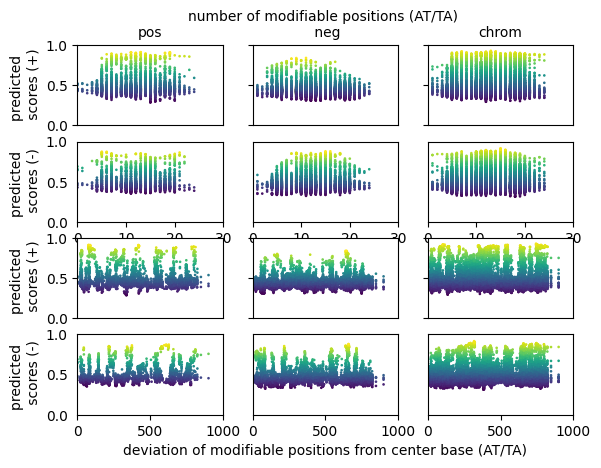

In [410]:
def plotPredictionScores(scores, modVars, modCounts, promoterStart, pStart, promoterEnd, pEnd, labels = ['pos', 'neg', 'chrom']):
    
    
    strands = [1, -1]
    group = 0
    for pos in range(1,4):
        ax = plt.subplot(4,3,pos)
        strand = strands[0]
        ax.margins(0.05)
        ax.scatter(x = modCounts[group][strand], y = scores[group][strand], 
                   s = 0.8, c = scores[group][strand], label = labels[group])
        ax.set_title(labels[group], size = 'medium')
        if pos ==2:
             ax.set_title('number of modifiable positions (AT/TA) \n neg', size = 'medium')            
        if pos == 1:
            ax.set_ylabel('predicted \n scores (+)')
            ax.tick_params(left = True, labelleft= True,
                           bottom = False, labelbottom = False)
        else:
            ax.tick_params(left = True, labelleft= False,
                           bottom = False, labelbottom = False)
        ax.set_ylim(0.0, 1.0)
        ax.set_xlim(0, 30)
        group +=1
    
    group = 0
    
    for pos in range(4, 7):
        ax = plt.subplot(4, 3, pos)
        strand = strands[1]
        ax.margins(0.05)
        ax.scatter(x = modCounts[group][strand], y = scores[group][strand], 
                   s = 0.8, c = scores[group][strand], label = labels[group])
        if pos == 4:
            ax.set_ylabel('predicted \n scores (-)')
            ax.tick_params(left = True, labelleft= True,
                           bottom = True, labelbottom = True)
        elif pos == 5:
            ax.tick_params(left = True, labelleft= False,
                           bottom = True, labelbottom = True)
        else:
            ax.tick_params(left = True, labelleft= False,
                           bottom = True, labelbottom = True)
        ax.tick_params(left = False)
        ax.set_ylim(0.0, 1.0)
        ax.set_xlim(0, 30)
        group +=1
    
    group = 0
    for pos in range(7, 10):
        ax = plt.subplot(4,3, pos)
        strand = strands[0]
        ax.margins(0.05)
        ax.scatter(x = modVars[group][strand], y = scores[group][strand], 
                   s = 0.8, c = scores[group][strand], label = labels[group])
        if pos == 7:
            ax.set_ylabel('predicted \n scores (+)')
            ax.tick_params(left = True, labelleft= True,
                           bottom = False, labelbottom = False)
        else:
            ax.tick_params(left = True, labelleft= False,
                           bottom = False, labelbottom = False)
        ax.set_ylim(0.0, 1.0)
        ax.set_xlim(0, 1000)
        group +=1
    
    group = 0
    
    for pos in range(10, 13):
        ax = plt.subplot(4,3, pos)
        strand = strands[1]
        ax.margins(0.05)
        ax.scatter(x = modVars[group][strand], y = scores[group][strand], 
                   s = 0.8, c = scores[group][strand], label = labels[group])
        if pos == 10:
            ax.set_ylabel('predicted \n scores (-)')
            ax.tick_params(left = True, labelleft= True,
                           bottom = True, labelbottom = True)
        elif pos == 11:
            ax.set_xlabel('deviation of modifiable positions from center base (AT/TA)')
            ax.tick_params(left = True, labelleft= False,
                           bottom = True, labelbottom = True)
        else:
            ax.tick_params(left = True, labelleft= False,
                           bottom = True, labelbottom = True)
        ax.tick_params(left = False)
        ax.set_ylim(0.0, 1.0)
        ax.set_xlim(0, 1000)
        group +=1

    return plt

plotPredictionScores(scores = [pos_scores, neg_scores, chrom_scores], 
                     modCounts = [pos_modCounts, neg_modCounts, chrom_modCounts], 
                     modVars= [pos_modVars, neg_modVars, chrom_modVars],
                     promoterStart = 66600, promoterEnd = 67700, pStart = pStart, pEnd = pEnd)
plt.savefig('../results/figures/231031_CLN2_modification_scores_vs_modifiable_positions.png', dpi = 1000)

In [353]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [401]:
def computeAUC(scores, true_lables, label = ['pos', 'neg']):
        
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    strands = [-1,1]
    
    for s in strands:
        y_true = np.array([int(i) for i in true_lables[0][s]] + [int(j) for j in true_lables[1][s]])
        y_test = np.array(scores[0][s] + scores[1][s])
        fpr[s], tpr[s], threshold = roc_curve(y_true, y_test)
        roc_auc[s] = auc(fpr[s], tpr[s])
    
    return fpr, tpr, roc_auc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


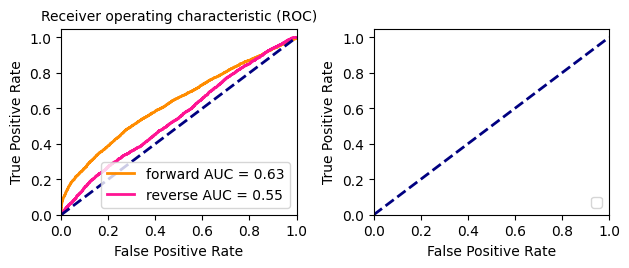

In [409]:
def plotROC(scores = [pos_scores, neg_scores], true_lables =  [pos_true_label, neg_true_label]):

    fpr, tpr, roc_auc = computeAUC(scores = scores, 
                            true_lables = true_lables)
    axL = plt.subplot(221)
    axL.plot(fpr[1], tpr[1], color="darkorange", lw=2,
        label="forward AUC = %0.2f" % roc_auc[1])
    
    axL.plot(fpr[-1], tpr[-1], color="deeppink", lw=2,
        label= "reverse AUC = %0.2f" % roc_auc[-1])
    
    axL.set_title("Receiver operating characteristic (ROC)", size = 'medium')

    axR = plt.subplot(222)

    for ax in [axL, axR]:
        ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend(loc="lower right")
    plt.tight_layout()

plotROC()

plt.savefig('../results/figures/231031_CLN2_ROC.png', dpi = 1000)

In [406]:
def plotModDistribution(pos_scores, neg_scores, chrom_scores, return_scores = False):
    '''
    plotModDistribution plot distribution of scores given aggregated prediction scores from evaluatePrediction
    '''
    fig, axs = plt.subplots(nrows=2, ncols=2, sharex = True, sharey = 'row')
    axs[0, 0].hist(pos_scores[-1], color='lightblue', bins = 30, label = 'pos', alpha=0.7)
    axs[0, 0].hist(neg_scores[-1], color='lightpink', bins = 30, label = 'neg', alpha=0.7)
    axs[0, 0].set_title('reverse strand cotrol')
    axs[0, 0].legend(prop ={'size': 10})
    axs[0, 1].hist(pos_scores[1], color='lightblue', bins = 30, label = 'pos', alpha=0.7)
    axs[0, 1].hist(neg_scores[1], color='lightpink', bins = 30, label = 'neg', alpha=0.7)
    axs[0, 1].set_title('forward strand control')

    axs[1, 0].hist(chrom_scores[-1], color='orange', bins = 30,)
    axs[1, 0].set_title('reverse strand chromatin')

    axs[1, 1].hist(chrom_scores[1], color='orange', bins = 30,)
    axs[1, 1].set_title('forward strand chromatin')
    
    if return_scores:
        return pos_scores, neg_scores, chrom_scores, positions, fig
    else:
        return fig

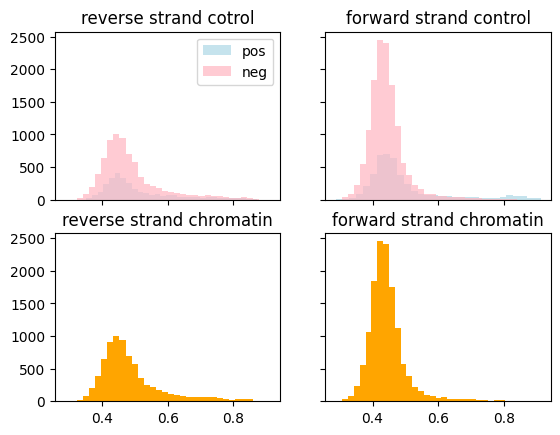

In [411]:
distPlot = plotModDistribution(pos_scores=pos_scores, neg_scores=neg_scores, chrom_scores=neg_scores)
plt.savefig('../results/figures/231031_CLN2_score_dist.png', dpi = 1000)